![imagen](../data/vacuna.jpg)
### <div align="center">***Efectividad de la vacuna de ARNm contra el SARS-Cov-2***</div>
***
En este estudio analizaremos la efectividad de la vacuna de ARNm contra la COVID-19. Para ello estudiaremos la evolucion de la COVID-19 en relación a la campaña de vacunación implementada en España. Nos preguntamos: *¿Cuáles son los cambios que se aprecian desde el inicio de la administración de las vacunas?*  

La población de estudio abarca a toda la población residente en España en el periodo de tiempo comprendido desde la detección del primer caso COVID en el país (31/01/2020), hasta la entrada en vigor de la nueva estategia de vigilancia (28/03/2022), por la que solo se notifican casos en individuos de 60 años o más.

##### **Importación de librerias y funciones auxiliares**

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.utils import LoadVacunas, dict_comunidades, ScrapISOdata

In [6]:
def ScrapISOdata():
    '''Función que scrapea un dataframe con los códigos ISO de todas las provincias de España y el correspondiente codigo ISO de su comunidad autónoma.
       Los códigos ISO son código estandarizados que identifican a las demarcaciones administrativa de cada país.

    Input: Ninguno
        
    Output: pd.DataFrame
    
    ''' 
    # Driver de Chrome de Selenium
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from webdriver_manager.chrome import ChromeDriverManager
    # Herramientas para buscar elementos
    from selenium.webdriver.common.by import By
    service = Service(ChromeDriverManager().install())
    import time
    from bs4 import BeautifulSoup as bs

    # 1- Mi instancia de driver de Chrome para scrapear
    driver = webdriver.Chrome(service=service)
    # 2- Seleccionamos url de la que queremos obtener datos y la solicitamos al sitio web (inician drivers -> abre el navegador)
    url = "https://www.iso.org/obp/ui/es/#iso:code:3166:ES"
    driver.get(url)
    # 3- Esperamos a que carge la pagina (10 segundos).
    time.sleep(10)
    # 4- Rescatamos el contenido html de la pagina web solicitada (codigo fuente)
    html = driver.page_source

    # 5- Buscamos los elementos 'table' (queremos obtener tabla de los codigos ISO de cada CC.AA y su correspondiente provincia)
    page = driver.find_elements(By.TAG_NAME, 'table')   
    # 6- Traduce o parsea el contenido html de la web. Devuelve un objeto bs donde buscaremos por etiqueta.
    soup = bs(html, "lxml")
    # 7- Buscamos las tablas que hay en la página con los atributos class e id. Nos devuelve una lista.
    table = soup.find("table", attrs = {'class':'tablesorter', 'id':'subdivision'})
    # 8- Seleccionamos la tabla que nos interesa de la lista y la cargamos con prettify de bs4 para que Pandas lo traduzca a df. https://stackoverflow.com/questions/41100451/load-scraped-table-via-bs4-into-pandas-dataframe
    ISO_CODE_DF = pd.read_html(table.prettify())[0]

    # 9- Aplicamos función Lambda para eliminar el "ES-" de los códigos ISO. 
    ISO_CODE_DF["Código 3166-2"] = ISO_CODE_DF["Código 3166-2"].apply( lambda x: str(x).replace("ES-", ""))
    ISO_CODE_DF["Subdivisión superior"] = ISO_CODE_DF["Subdivisión superior"].apply( lambda x: str(x).replace("ES-", ""))


    # Seleccionamos el contenido de la tabla que nos interesa (filas con el codigo ISO de las provincias y el de su equivalente CC.AA)
    ISO_DF = ISO_CODE_DF.loc[ ISO_CODE_DF["Categoría de la subdivisión"] == "province" ][["Código 3166-2", "Subdivisión superior" ]]\
        .drop_duplicates().reset_index().drop(columns="index")

    # Agregamos filas al df para Ceuta, Melilla y No Contesta (NC).
    row_1 = {"Código 3166-2": "CE", "Subdivisión superior": "CE"}
    row_2 = {"Código 3166-2": "ML", "Subdivisión superior": "ML"}
    row_3 = {"Código 3166-2": "NC", "Subdivisión superior": "NC"}
    ISO_DF = ISO_DF.append(row_1, ignore_index=True)
    ISO_DF = ISO_DF.append(row_2, ignore_index=True)
    ISO_DF = ISO_DF.append(row_3, ignore_index=True)

    return ISO_DF

##### **Datos de los tipos de vacunas entregadas a cada CC.AA y cifras población en 2021 según el INE**

In [7]:
## Vacunas entregadas por tipo a cada CC.AA y España (frecuencia relativa)

tipos_vacuna_ccaa = pd.read_excel('./docsEDA/TiposVacunas.xlsx', sheet_name = 'Hoja1', index_col = "Comunidad") # Vacunas entregadas por tipo en CC.AA 
tipos_vacuna_total= pd.read_excel('./docsEDA/TiposVacunas.xlsx', sheet_name = 'Hoja2', index_col = "Comunidad") # Vacunas-tipo en España desglosadas

## Datos poblacionales por CC.AA (padrón municipal del 2021 por el Instituto Nacional Estadística)

poblacion= pd.read_excel('./docsEDA/PoblacionEspaña2021INE.xlsx', index_col = "Comunidad")

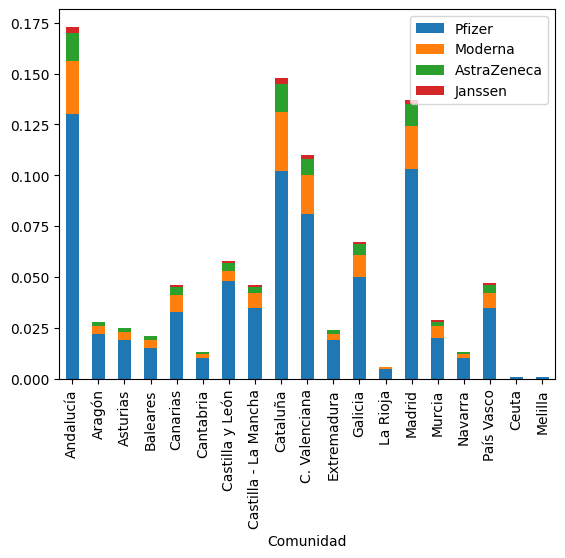

In [8]:
## Diagrama de barras apiladas de las vacunas entregadas a cada CC.AA y de las vacunas entregadas por tipo dentro de cada CC.AA (frecuencias relativas) 
# Variable principal: Vacunas entregadas de cada CC.AA en frecuencia relativa (proporción respecto al total de entregadas)

for col in tipos_vacuna_ccaa.columns[0:-1]: # Itera sobre cada columna y la multiplica por la columna de frecuencia relativa correspondiente con la CC.AA.
    tipos_vacuna_ccaa[col] =  round(tipos_vacuna_ccaa[col] * tipos_vacuna_ccaa["FR_CC.AA"], 3)

tipos_vacuna_ccaa.drop(["Dosis entregadas","FR_administradas-entregadas","FR_CC.AA"], axis=1).drop("España", axis=0).plot(kind='bar', stacked=True);

Como apreciamos en la gráfica, nos enfrentamos a una población vacunada mayoritariamente con vacunas de ARNm (Moderna y Pfizer).  
  
  
***Aspecto a cosiderar***: Los datos que observamos acerca de los tipos de vacunas son de vacunas entregadas a las comunidades autónomas, pero como de acuerdo a los datos el porcentaje de vacunas administradas frente a las entregadas supera el 95% en España, los consideraremos equivalentes.

In [9]:
tipos_vacuna_ccaa[["FR_administradas-entregadas"]] # Desglose del porcentaje de vacunas administradas sobre entregadas.

,FR_administradas-entregadas
Comunidad,
España,0.959481
Andalucía,0.991624
Aragón,0.954992
Asturias,0.951211
Baleares,0.939796
Canarias,0.874837
Cantabria,0.962932
Castilla y León,0.945051
Castilla - La Mancha,0.876015


,Pfizer,Pfizer pediátrica,Pfizer adaptada,Moderna,Moderna adaptada,AstraZeneca,Janssen,FR_administradas-entregadas
Comunidad,,,,,,,,
España,0.579609,0.042639,0.117944,0.153977,0.005911,0.081518,0.018402,0.959481


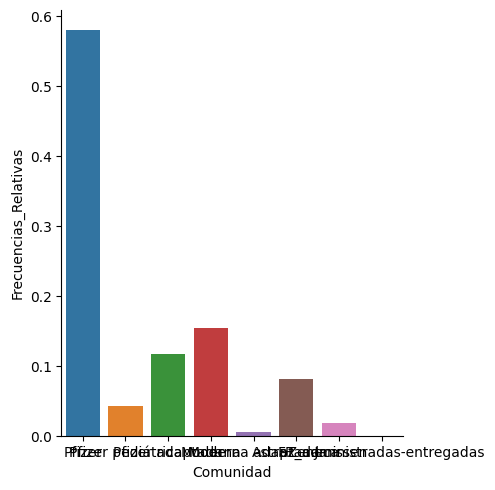

In [10]:
## Diagrama de barras de vacunas por tipo entregadas a España (frecuencias relativas)

ejex = pd.Series(tipos_vacuna_total.columns)
ejey = pd.Series(tipos_vacuna_total.values[0][:-1])
plot_vacuna_total = pd.concat([ejey,ejex], axis=1)
plot_vacuna_total.columns =["Frecuencias_Relativas","Comunidad"] 

sns.catplot(x = "Comunidad", y = "Frecuencias_Relativas", kind = "bar", data = plot_vacuna_total)

display(tipos_vacuna_total) # Tabla de vacunas desglosadas por tipo.

##### **Datos de la evolución de la vacunacion por CC.AA: Individuos con al menos una dosis, pauta completa y dosis de recuerdo**

In [11]:
## Evolución de la vacunacion por CC.AA en España

lista_comunidades = [
('./docsEDA/EvolucionVacunas.xlsx', 'AN'),        # Andalucía
('./docsEDA/EvolucionVacunas.xlsx', 'AR'),        # Aragon
('./docsEDA/EvolucionVacunas.xlsx', 'AS'),        # Asturias
('./docsEDA/EvolucionVacunas.xlsx', 'IB'),        # Baleares
('./docsEDA/EvolucionVacunas.xlsx', 'CN'),        # Canarias
('./docsEDA/EvolucionVacunas.xlsx', 'CB'),        # Cantabria
('./docsEDA/EvolucionVacunas.xlsx', 'CT'),        # Cataluña
('./docsEDA/EvolucionVacunas.xlsx', 'CE'),        # Ceuta
('./docsEDA/EvolucionVacunas.xlsx', 'EX'),        # Extremadura
('./docsEDA/EvolucionVacunas.xlsx', 'GA'),        # Galicia
('./docsEDA/EvolucionVacunas.xlsx', 'CL'),        # Castilla y León
('./docsEDA/EvolucionVacunas.xlsx', 'CM'),        # Castilla-La Mancha
('./docsEDA/EvolucionVacunas.xlsx', 'MD'),        # Madrid
('./docsEDA/EvolucionVacunas.xlsx', 'ML'),        # Melilla
('./docsEDA/EvolucionVacunas.xlsx', 'MC'),        # Murcia
('./docsEDA/EvolucionVacunas.xlsx', 'NC'),        # Navarra
('./docsEDA/EvolucionVacunas.xlsx', 'RI'),        # La Rioja
('./docsEDA/EvolucionVacunas.xlsx', 'VC'),        # La Rioja
('./docsEDA/EvolucionVacunas.xlsx', 'PV')         # Pais Vasco
]

## Unión de todos los dataset de vacunacion de cada CC.AA en uno.

evol_vac_esp = LoadVacunas(lista_comunidades)
evol_vac_esp.fillna(0, inplace = True)      # 5643 datos por columna ; 3648 NaN sustituidos por 0
evol_vac_esp ["Dosis_Recuerdo"] = evol_vac_esp["Dosis_Recuerdo"].apply(lambda x: round(x)) # Transformamos datos a enteros -> unidades de observacion: personas.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


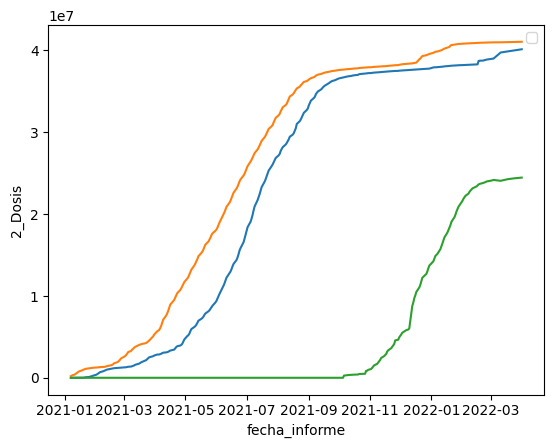

In [12]:
## Gráfico de la evolución de la campaña de vacunación en España: Serie temporal (poblacion con 1 dosis, pauta completa y dosis de recuerdo)

grafico_vac_esp = evol_vac_esp.groupby("fecha_informe",  as_index = False).agg({"1_Dosis":"sum", "2_Dosis" : "sum",	"Dosis_Recuerdo" : "sum"})

sns.lineplot(x = "fecha_informe", y = '2_Dosis',data = grafico_vac_esp)
sns.lineplot(x = "fecha_informe", y = '1_Dosis',data = grafico_vac_esp)
sns.lineplot(x = "fecha_informe", y = 'Dosis_Recuerdo',data = grafico_vac_esp)
plt.legend();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


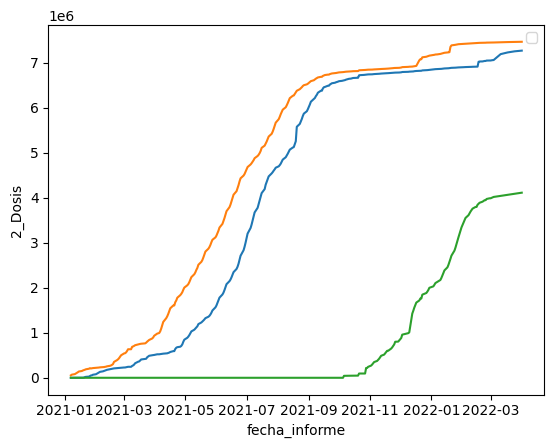

In [13]:
## Gráfico de la evolucion de la campaña de vacunación por CC.AA (Andalucia y Madrid)

evol_vac_an = pd.read_excel('./docsEDA/EvolucionVacunas.xlsx', sheet_name = 'AN') # Andalucía
evol_vac_an.fillna(0, inplace = True) ; evol_vac_an ["Dosis_Recuerdo"] = evol_vac_an["Dosis_Recuerdo"].apply(lambda x: round(x)) 

sns.lineplot(x = "fecha_informe", y = '2_Dosis',data = evol_vac_an)  
sns.lineplot(x = "fecha_informe", y = '1_Dosis',data = evol_vac_an)
sns.lineplot(x = "fecha_informe", y = 'Dosis_Recuerdo',data = evol_vac_an)
plt.legend();

# evol_vac_md = pd.read_excel('./docsEDA/EvolucionVacunas.xlsx', sheet_name = 'MD') # Madrid
# evol_vac_md.fillna(0, inplace = True) ; evol_vac_md ["Dosis_Recuerdo"] = evol_vac_md["Dosis_Recuerdo"].apply(lambda x: round(x)) 


# sns.lineplot(x = "fecha_informe", y = '2_Dosis',data = evol_vac_md)  
# sns.lineplot(x = "fecha_informe", y = '1_Dosis',data = evol_vac_md)
# sns.lineplot(x = "fecha_informe", y = 'Dosis_Recuerdo',data = evol_vac_md)
# plt.legend();


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


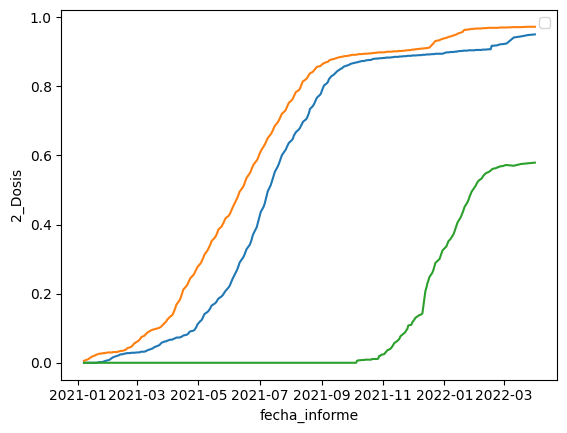

In [14]:
## Evolución de la campaña de vacunación en España con frecuencias relativas (proporción respecto al total de poblacion de cada CC.AA)

porcentajes_vacunacion_esp = evol_vac_esp.groupby(["fecha_informe"], as_index = False).agg({'2_Dosis':"sum","1_Dosis" : "sum", "Dosis_Recuerdo" : "sum"})  

for col in porcentajes_vacunacion_esp.columns[1:4]:  # Itera sobre las columnas del df y calcula el porcentaje de vacunados respecto al total de hab de España.
     porcentajes_vacunacion_esp[col] =  round(porcentajes_vacunacion_esp[col] / (sum(poblacion["Habitantes"])), 3)

sns.lineplot(x = "fecha_informe", y = '2_Dosis',data = porcentajes_vacunacion_esp)  
sns.lineplot(x = "fecha_informe", y = '1_Dosis',data = porcentajes_vacunacion_esp)
sns.lineplot(x = "fecha_informe", y = 'Dosis_Recuerdo',data = porcentajes_vacunacion_esp)
plt.legend();

In [15]:
## Exportación de df creados a xlsx para visualización en Tableau:

poblacion["ISO"] = pd.Series(dict_comunidades)
evol_vac_esp = evol_vac_esp.merge(poblacion, left_on="ISO", right_on="ISO", how='left')

porcentajes_vacunacion_ccaa = evol_vac_esp.copy() # Itera sobre las columnas del df y calcula el porcentaje de vacunados respecto al total de hab de cada CC.AA.
for col in porcentajes_vacunacion_ccaa.columns[1:4]:  
    porcentajes_vacunacion_ccaa[col] =  round(porcentajes_vacunacion_ccaa[col] / porcentajes_vacunacion_ccaa["Habitantes"], 3)

#porcentajes_vacunacion_ccaa.to_excel(".\porcentaje_vacunacion_ccaa.xlsx", index=False) # https://es.stackoverflow.com/questions/414477/exportar-datos-dataframe-a-excel-python
#porcentajes_vacunacion_esp.to_excel(".\porcentaje_vacunacion_ccaa.xlsx", index=False) #https://es.stackoverflow.com/questions/414477/exportar-datos-dataframe-a-excel-python

En los gráficos se aprecia que la cantidad de población vacunada va aumentando considerablemente hasta llegar a un porcentaje respecto a la población mayor de 12 años cercado al 100% en la mayoría de CC.AA. 

***A considerar:*** Los calculos de las frecuencias relativas se hacen sobre la población residente en España mayor de 12 años, que son los grupos de edad a los que fue dirigida a priori la campaña de vacunación.

##### **Datos de la evolución de la COVID-19 por CC.AA: casos confirmados, casos hospitalizados, ingresos UCI y defunciones**

In [16]:
## Evolución de la COVID-19 por CC.AA: casos confirmados, hospitalizados, ingresos UCI y defunciones.

crisis_covid = pd.read_csv('./docsEDA/EvolucionCovid.csv', sep=',') # Dataset original muestra datos por provincia

# Filtramos el dataset para quitar datos anteriores a la fecha del primer caso COVID (31/01/2020). Agrupamos por provincia, grupos de edad y fecha.
# as_index = False para que el DataFrame resultante no tenga las columnas de agrupación como índice. https://sparkbyexamples.com/pandas/pandas-aggregate-functions-with-examples/
crisis_covid = crisis_covid.loc[ (crisis_covid['fecha'] >= "2020-01-31") ].groupby(["provincia_iso","grupo_edad","fecha"],\
              as_index = False).agg({"num_casos":"sum", "num_hosp" : "sum",	"num_uci" : "sum",	"num_def" : "sum" }) 

In [17]:
ISO_DF = ScrapISOdata()  # Tabla de codigos ISO scrapeada de https://www.iso.org/obp/ui/es/#iso:code:3166:ES

# Left join con la tabla de ISO. Obtenemos los ISO code de cada comunidad autónoma para cada provincia
evolucion_covid = crisis_covid.merge(ISO_DF, left_on="provincia_iso", right_on="Código 3166-2", how='left') 

# Agrupación para mostrar datos por comunidad autónoma, especificado un orden concreto. 
evolucion_covid= evolucion_covid.groupby(["Subdivisión superior","grupo_edad","fecha"], as_index = False).agg({"num_casos":"sum", "num_hosp" : "sum",\
                           "num_uci" : "sum", "num_def" : "sum" }).sort_values(by=["Subdivisión superior","fecha", "grupo_edad"], ascending=True)

In [18]:
#evolucion_covid.to_excel(".\evolcuion_covid.xlsx", index=False) # https://es.stackoverflow.com/questions/414477/exportar-datos-dataframe-a-excel-python

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


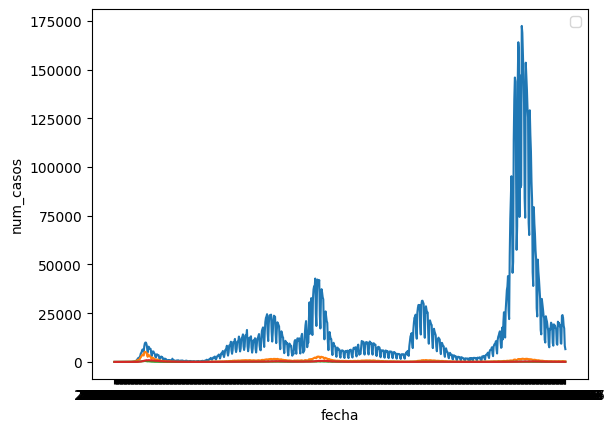

In [19]:
## Gráfico de la evolucion de la COVID-19 en España: Serie temporal (casos confirmados, hospitalizados, ingresos UCI y defunciones)

evolucion_covid_esp = evolucion_covid.groupby("fecha", as_index = False).agg({"num_casos":"sum","num_hosp" : "sum",	"num_uci" : "sum",\
                  "num_def" : "sum"})       
                                    
sns.lineplot(x = "fecha", y = 'num_casos',data = evolucion_covid_esp)
sns.lineplot(x = "fecha", y = 'num_hosp',data = evolucion_covid_esp)
sns.lineplot(x = "fecha", y = 'num_uci',data = evolucion_covid_esp)
sns.lineplot(x = "fecha", y = 'num_def',data = evolucion_covid_esp)
plt.legend();

<AxesSubplot:xlabel='fecha', ylabel='num_def'>

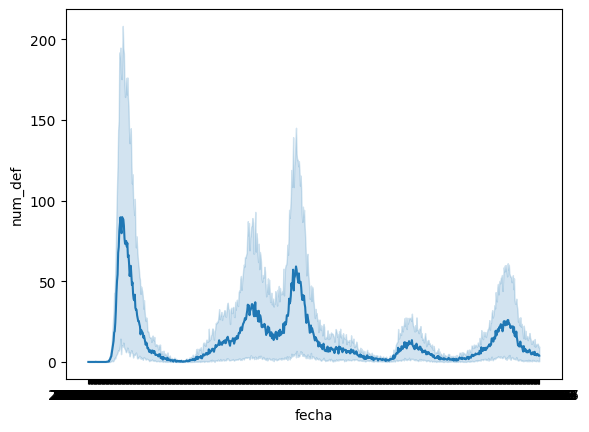

In [20]:
## Gráficos de la evolucion de la COVID-19 en España por grupos de edad: Serie temporal (casos confirmados, hospitalizados, ingresos UCI y defunciones)

evolucion_covid_edad = evolucion_covid.groupby(["fecha","grupo_edad"], as_index = False).agg({"num_casos":"sum","num_hosp" : "sum",	"num_uci" : "sum",\
                  "num_def" : "sum"})
                                        
sns.lineplot(x = "fecha", y = 'num_def',data = evolucion_covid_edad)  # Defunciones por grupo de edad

<AxesSubplot:xlabel='fecha', ylabel='num_hosp'>

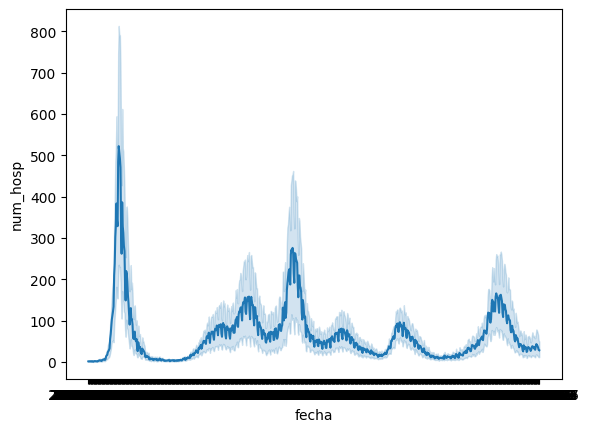

In [21]:
sns.lineplot(x = "fecha", y = 'num_hosp',data = evolucion_covid_edad) # Hospitalizados por grupos de edad

<AxesSubplot:xlabel='fecha', ylabel='num_uci'>

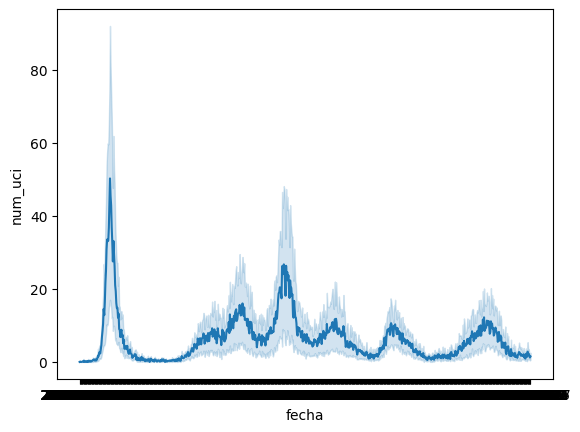

In [22]:
sns.lineplot(x = "fecha", y = 'num_uci',data = evolucion_covid_edad) # Ingresos en UCI por grupos de edad

<AxesSubplot:xlabel='fecha', ylabel='num_casos'>

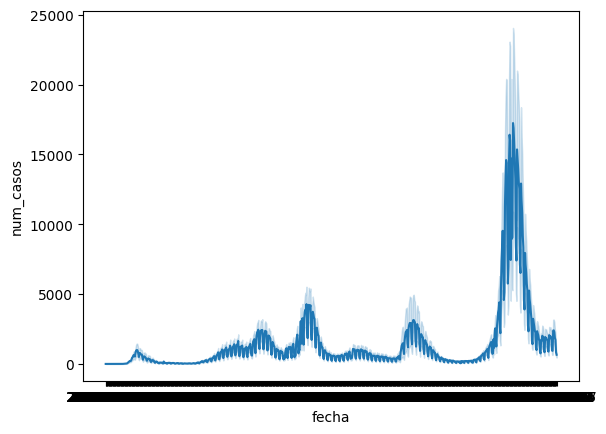

In [23]:
sns.lineplot(x = "fecha", y = 'num_casos',data = evolucion_covid_edad) # Casos confirmados por grupos de edad

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


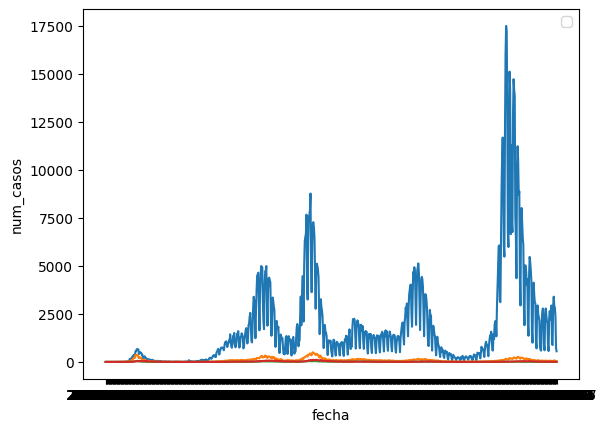

In [24]:
## Gráfico de la evolucion de la COVID-19 en Andalucía: Serie temporal (casos confirmados, hospitalizados, ingresos UCI y defunciones)

evol_covid_an = evolucion_covid[evolucion_covid["Subdivisión superior"] =="AN"] # Aplico una máscara para filtrar por comunidad autonoma
evolucion_covid_an = evol_covid_an.groupby("fecha", as_index = False).agg({"num_casos":"sum","num_hosp" : "sum", "num_uci" : "sum",\
                  "num_def" : "sum"})              
                        
sns.lineplot(x = "fecha", y = 'num_casos',data = evolucion_covid_an)
sns.lineplot(x = "fecha", y = 'num_hosp',data = evolucion_covid_an)
sns.lineplot(x = "fecha", y = 'num_uci',data = evolucion_covid_an)
sns.lineplot(x = "fecha", y = 'num_def',data = evolucion_covid_an)
plt.legend();

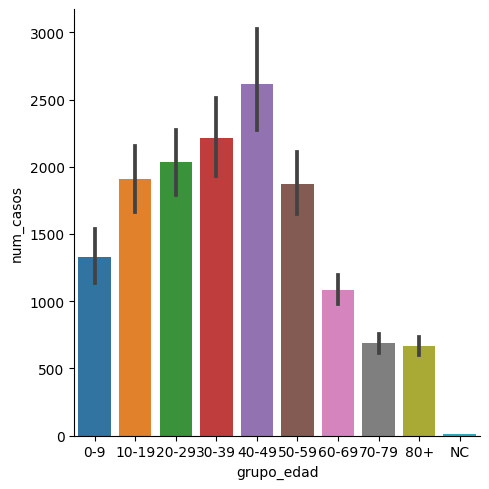

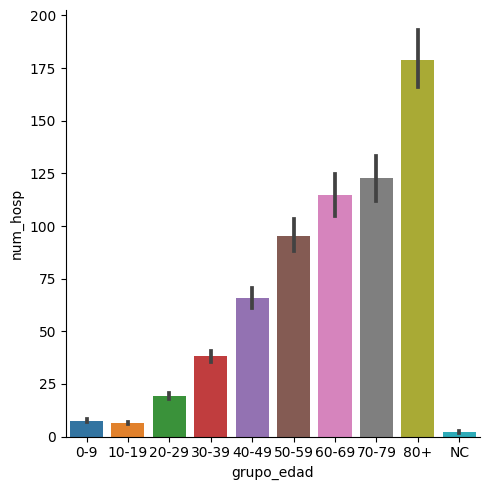

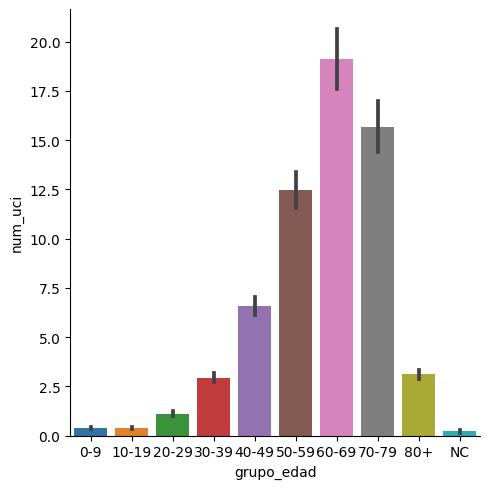

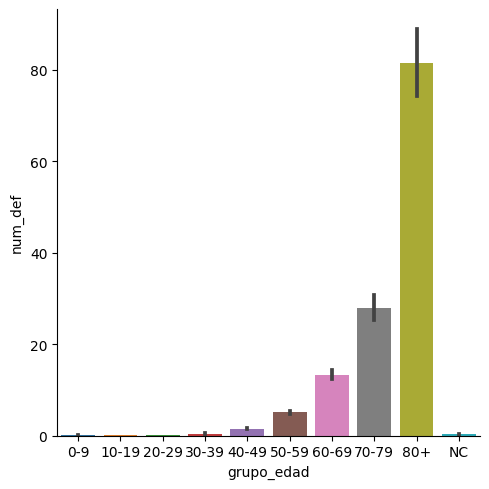

In [25]:
# Diagramas de barras de casos confirmados, hospitalizados, ingresos en UCI y defunciones por grupos de edad en España (frecuencias absolutas)

sns.catplot(x = "grupo_edad", y = "num_casos", kind = "bar", data = evolucion_covid_edad) # Número de casos confirmados
sns.catplot(x = "grupo_edad", y = "num_hosp", kind = "bar", data = evolucion_covid_edad)  # Número de casos hospitalizados
sns.catplot(x = "grupo_edad", y = "num_uci", kind = "bar", data = evolucion_covid_edad)   # Número de ingresos en UCI
sns.catplot(x = "grupo_edad", y = "num_def", kind = "bar", data = evolucion_covid_edad)   # Número de defunciones

- La mayoría de los casos confirmados son personas entre 40-49 años de edad.
- La mayoría de hospitalizados son personas mayores de 80 años de edad.
- La mayoría de los ingresos en UCI son personas entre 60-69 años de edad..
- La mayoría de los casos de defunciones son personas mayores de 80 años de edad.

Se aprecian las oleadas en funcion del aumento de estos parámetros.

##### **Creación dataframe para Tableau**  
Para trabajar con datos en Tableau necesitamos un unico dataframe, asi que cruzamos los datos de los dataset de vacunación y el de casos COVID para crear un unico dataframe.

In [79]:
lista_g_v = evolucion_covid["grupo_edad"].unique()
columns_list = ["num_casos", "num_hosp", "num_uci", "num_def"]

df_j = evolucion_covid.copy()

def df_column_generator(df, grupo_edad, column):
    ged = df["grupo_edad"]
    numc = df[column]
    r_col = []

    for x, y in zip(ged, numc):
        if x == grupo_edad and y != 0: 
            
            r_col.append(y)
        else: 
            r_col.append(0)
    
    return r_col

for x in lista_g_v:
    for i in columns_list: 
        df_j[f"{x}_{i}"] = df_column_generator(df_j, x, i)

In [114]:
group_by_cols = ["fecha", "Subdivisión superior"]
sum_columns = [x for x in df_j.columns if x not in group_by_cols ]
pre_final_df = df_j.groupby(group_by_cols, as_index=False)[sum_columns].agg("sum", )

In [115]:
porcentajes_vacunacion_ccaa
porcentajes_vacunacion_ccaa["fecha_informe"] = porcentajes_vacunacion_ccaa["fecha_informe"].astype(str)

In [ ]:
final_df = pre_final_df.merge(porcentajes_vacunacion_ccaa, left_on=["fecha","Subdivisión superior"], right_on=["fecha_informe", "ISO"], how="left").drop(["Habitantes", "ISO", "fecha_informe"], axis=1)

In [130]:
#final_df.to_excel("./Efectividad_Tableau.xlsx")